# Pyro HDP-HSMM-Like Code

In [9]:
import pickle
import torch
from collections import defaultdict




Loaded 10 groups with 1787 total coins.
[0] ELBO: 1749476263.56
[500] ELBO: 224776240.24
[1000] ELBO: 31110386071.64
[1500] ELBO: 241509511.46
[2000] ELBO: 19936813.50
[2500] ELBO: 18527352907.00


/tmp/ipykernel_40401/3177792714.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(group_data))


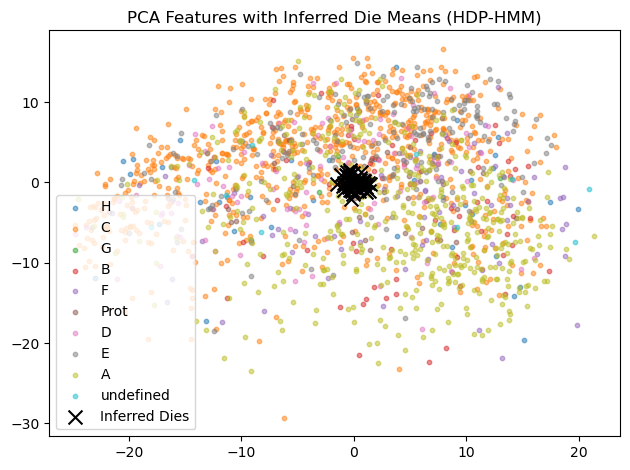

In [10]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

# Setup
pyro.clear_param_store()
torch.manual_seed(0)
device = torch.device("cpu")

# Configuration
num_states = 50         # Truncation level (max dies)
#obs_dim = 2             # Coin feature dimension (e.g., PCA/CNN-reduced)
#obs_dim = reduced.shape[1]  # Use 100 if that's your PCA dim

# Load saved features
with open("coin_features_pca_coin_clip.pkl", "rb") as f:
    data = pickle.load(f)

features = data["features"]
labels = data["labels"]
obs_dim = features.shape[1]

# Group features by label
grouped_features = defaultdict(list)
for feat, label in zip(features, labels):
    grouped_features[label].append(feat)

# Convert to torch tensors
group_data = [torch.tensor(v, dtype=torch.float32) for v in grouped_features.values()]
group_names = list(grouped_features.keys())

print(f"Loaded {len(group_data)} groups with {sum(len(g) for g in group_data)} total coins.")
# EXAMPLE DATA
#group_data = [
#    torch.cat(simulate_group([10, 15, 10], [[0, 0], [5, 5], [0, 0]])),
#    torch.cat(simulate_group([20, 10], [[5, 5], [8, -2]])),
#    torch.cat(simulate_group([12, 18], [[0, 0], [8, -2]]))
#]

# Ensure all are float32
#group_data = [seq.float() for seq in group_data]

# --- HDP Mixture Model (simplified HDP-HMM) ---
def model(groups):
    beta_k = pyro.sample("beta_k", dist.Beta(1., 1.).expand([num_states]).to_event(1))

    beta = torch.cat([beta_k, 1 - beta_k.sum().unsqueeze(0)], dim=0)

    mus = pyro.sample("mus", dist.Normal(torch.zeros(num_states, obs_dim), 5.0).to_event(2))
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(num_states, obs_dim)).to_event(2))

    for g, seq in enumerate(groups):
        pi = pyro.sample(f"pi_{g}", dist.Dirichlet(beta[:-1] + 0.1))

        with pyro.plate(f"obs_{g}", seq.shape[0]):
            z = pyro.sample(f"z_{g}", dist.Categorical(pi), infer={"enumerate": "parallel"})
            pyro.sample(f"x_{g}", dist.Normal(mus[z], sigmas[z]).to_event(1), obs=seq)

# --- Guide (variational posterior) ---
def guide(groups):
    beta_k_q = pyro.param("beta_k_q", lambda: torch.rand(num_states), constraint=dist.constraints.unit_interval)
    pyro.sample("beta_k", dist.Delta(beta_k_q).to_event(1))

    mus_loc = pyro.param("mus_loc", lambda: torch.randn(num_states, obs_dim))
    mus_scale = pyro.param("mus_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
    pyro.sample("mus", dist.Normal(mus_loc, mus_scale).to_event(2))

    sigmas_scale = pyro.param("sigmas_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
    pyro.sample("sigmas", dist.HalfCauchy(sigmas_scale).to_event(2))

    for g in range(len(groups)):
        alpha = pyro.param(f"alpha_{g}", lambda: torch.ones(num_states), constraint=dist.constraints.positive)
        pyro.sample(f"pi_{g}", dist.Dirichlet(alpha))

# --- Training ---
#optimizer = Adam({"lr": 0.01})
#svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

#num_steps = 3000
#for step in range(num_steps):
#    loss = svi.step(group_data)
#    if step % 500 == 0:
#        print(f"[{step}] ELBO: {loss:.2f}")

# Start the HDP-HMM model training
svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

num_steps = 3000
for step in range(num_steps):
    loss = svi.step(group_data)
    if step % 500 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")


# --- Posterior Visualization ---
#mus_post = pyro.param("mus_loc").detach()
#colors = ['red', 'blue', 'green']

#for i, seq in enumerate(group_data):
#    plt.scatter(seq[:, 0], seq[:, 1], color=colors[i], alpha=0.5, label=f'Group {i+1}')

#plt.scatter(mus_post[:, 0], mus_post[:, 1], color='black', marker='x', s=100, label='Inferred Dies')
#plt.title("Coin Feature Space with Inferred Die Means")
#plt.legend()
#plt.xlabel("Feature 1")
#plt.ylabel("Feature 2")
#plt.tight_layout()
#plt.show()

# Inferred die (state) locations
mus_post = pyro.param("mus_loc").detach().cpu()
colors = plt.cm.get_cmap('tab10', len(group_data))

# Plot group PCA features
for i, (group_tensor, name) in enumerate(zip(group_data, group_names)):
    arr = group_tensor.numpy()
    plt.scatter(arr[:, 0], arr[:, 1], label=name, alpha=0.5, s=10, color=colors(i))

# Plot inferred die means
plt.scatter(mus_post[:, 0], mus_post[:, 1], color='black', marker='x', s=100, label='Inferred Dies')
plt.title("PCA Features with Inferred Die Means (HDP-HMM)")
plt.legend()
plt.tight_layout()
plt.show()


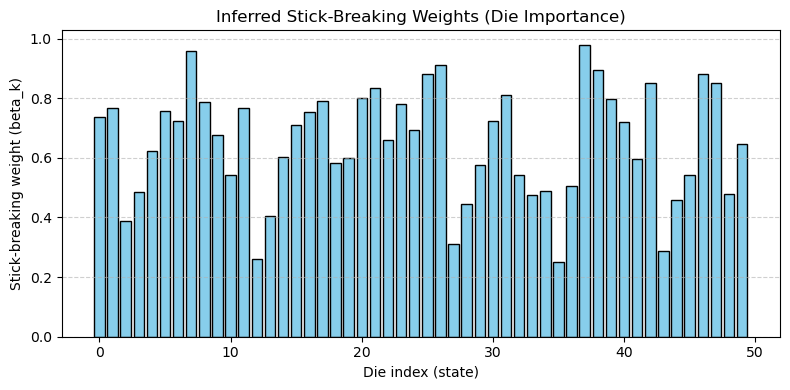

Estimated number of used dies (states): 50 out of 50


In [11]:
# Get stick-breaking weights
beta_k = pyro.param("beta_k_q").detach().cpu().numpy()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(range(len(beta_k)), beta_k, color='skyblue', edgecolor='black')
plt.xlabel("Die index (state)")
plt.ylabel("Stick-breaking weight (beta_k)")
plt.title("Inferred Stick-Breaking Weights (Die Importance)")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Report number of used states
used_states = (beta_k > 0.01).sum()
print(f"Estimated number of used dies (states): {used_states} out of {len(beta_k)}")


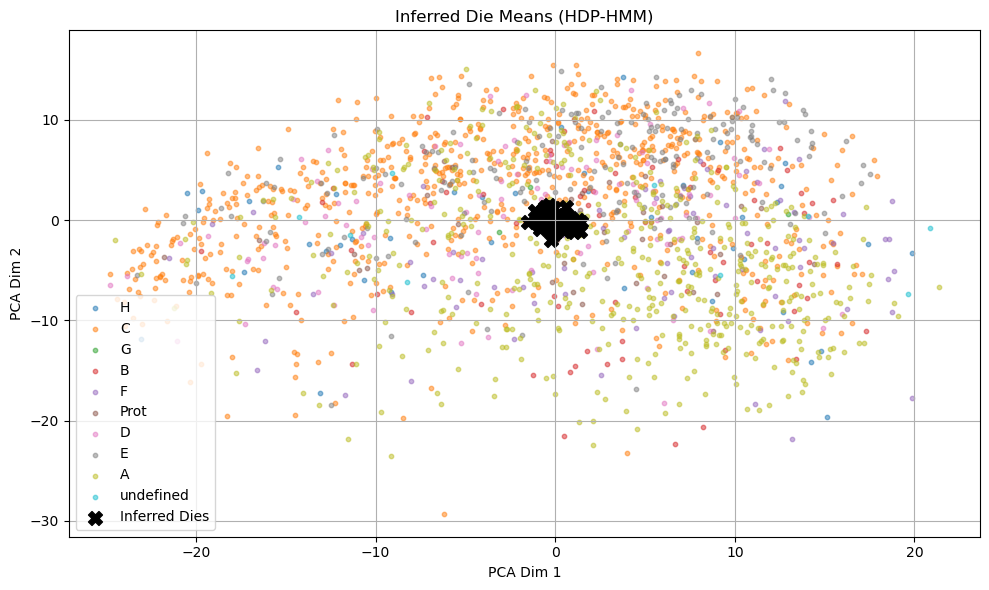

In [12]:
mus = pyro.param("mus_loc").detach().cpu().numpy()

# PCA scatter again
plt.figure(figsize=(10, 6))
for i, (group_tensor, name) in enumerate(zip(group_data, group_names)):
    arr = group_tensor.numpy()
    plt.scatter(arr[:, 0], arr[:, 1], label=name, s=10, alpha=0.5)

# Overlay inferred die means
plt.scatter(mus[:, 0], mus[:, 1], color='black', marker='X', s=100, label='Inferred Dies')
plt.title("Inferred Die Means (HDP-HMM)")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
